In [56]:
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import random
from collections import deque
import matplotlib.pyplot as plt

In [57]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1
!pip install colabgymrender==1.0.2

In [58]:
from colabgymrender.recorder import Recorder

In [59]:
# install dependencies
!apt install chromium-browser xvfb

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
chromium-browser is already the newest version (1:85.0.4183.83-0ubuntu2.22.04.1).
xvfb is already the newest version (2:21.1.4-2ubuntu1.7~22.04.10).
0 upgraded, 0 newly installed, 0 to remove and 44 not upgraded.


In [ ]:
env = gym.make('CartPole-v0')
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0

while not done:
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action)
    total_reward += reward
    state = next_state

print(total_reward)
env.play()


  logger.warn(

  deprecation(

  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  if not isinstance(terminated, (bool, np.bool8)):



24.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


In [ ]:
total_reward

  and should_run_async(code)



24.0

In [ ]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.01
max_num_steps = 50000
epsilon_decay_intervals = 10000
gamma = 0.99 # discount
alpha = 5e-4 # learning rate

memory_size = 50000
min_replay_size = 1000
batch_size = 32

target_update_frequency = 1000 # target network update frequency

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, env):
        super(NeuralNetwork, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        return self.network(state)

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0)) # pytorch requires inputs in terms of batch
        best_action = torch.argmax(q_values, dim=1)[0]

        return best_action.detach().item()

In [ ]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [ ]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = NeuralNetwork(env)
    target_net = NeuralNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100) # Rewards of the previous 100 episodes

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0,1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0


        # Take a batch of experiences from the memory
        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1) # (batch_size,) --> (batch_size, 1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        # Compute targets using the formulation sample = r + gamma * max q(s',a')
        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1-dones) * max_target_q_values

        # Compute loss
        q_values = q_net(states)

        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        # gradient descent for q-network
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # update target network
        if (step+1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        # print training results
        if (step+1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step+1} Average reward: {average_reward}')

    return all_rewards, q_net

In [ ]:
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

  states = torch.tensor(states, dtype=torch.float32)



Episode: 44 Step: 1000 Average reward: 22.727272727272727
Episode: 91 Step: 2000 Average reward: 21.802197802197803
Episode: 141 Step: 3000 Average reward: 20.67
Episode: 178 Step: 4000 Average reward: 23.26
Episode: 201 Step: 5000 Average reward: 27.86
Episode: 222 Step: 6000 Average reward: 33.48
Episode: 237 Step: 7000 Average reward: 40.81
Episode: 251 Step: 8000 Average reward: 47.48
Episode: 263 Step: 9000 Average reward: 53.93
Episode: 269 Step: 10000 Average reward: 60.77
Episode: 275 Step: 11000 Average reward: 70.38
Episode: 280 Step: 12000 Average reward: 78.04
Episode: 285 Step: 13000 Average reward: 86.45
Episode: 290 Step: 14000 Average reward: 93.62
Episode: 295 Step: 15000 Average reward: 101.23
Episode: 300 Step: 16000 Average reward: 109.29
Episode: 305 Step: 17000 Average reward: 117.63
Episode: 310 Step: 18000 Average reward: 125.98
Episode: 315 Step: 19000 Average reward: 133.32
Episode: 320 Step: 20000 Average reward: 140.33
Episode: 325 Step: 21000 Average reward

  and should_run_async(code)



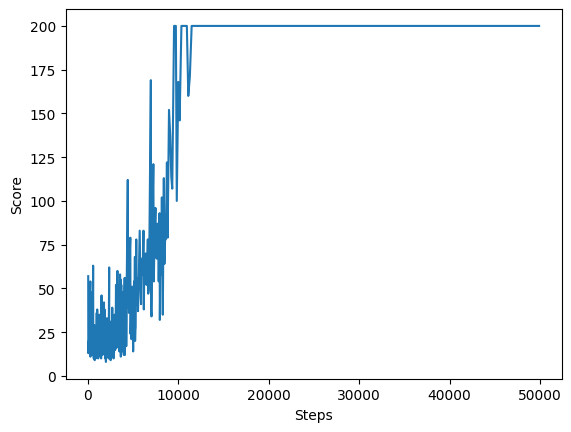

In [ ]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [ ]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



200.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


  and should_run_async(code)



# **MountainCar-v0**

In [60]:
class DuellingNetwork(nn.Module):
    def __init__(self, env):
        super(DuellingNetwork, self).__init__()
        self.feature_layer = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 64),
            nn.Tanh()
        )
        self.value_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, 1)
        )
        self.advantage_stream = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, env.action_space.n)
        )

    def forward(self, state):
        features = self.feature_layer(state)
        values = self.value_stream(features)
        advantages = self.advantage_stream(features)
        qvals = values + (advantages - advantages.mean(dim=1, keepdim=True))
        return qvals

    def choose_action(self, state):
        state = torch.tensor(state, dtype=torch.float32)
        q_values = self(state.unsqueeze(0))
        best_action = torch.argmax(q_values, dim=1)[0]
        return best_action.detach().item()

In [61]:
def fill_memory(env):
    memory = deque(maxlen=memory_size)
    state = env.reset()
    for _ in range(min_replay_size):
        action = env.action_space.sample()
        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        state = next_state
        if done:
            env.reset()

    return memory

In [62]:
def dqn_training(env, max_num_steps, max_epsilon, min_epsilon, num_epsilon_decay_intervals, gamma, lr):
    q_net = DuellingNetwork(env)
    target_net = DuellingNetwork(env)
    target_net.load_state_dict(q_net.state_dict())
    optimizer = torch.optim.Adam(q_net.parameters(), lr=lr)

    memory = fill_memory(env)
    reward_buffer = deque(maxlen=100)

    reward_per_episode = 0.0
    state = env.reset()
    all_rewards = []
    for step in range(max_num_steps):
        epsilon = np.interp(step, [0, num_epsilon_decay_intervals], [max_epsilon, min_epsilon])

        random_number = np.random.uniform(0, 1)
        if random_number <= epsilon:
            action = env.action_space.sample()
        else:
            action = q_net.choose_action(state)

        next_state, reward, done, info = env.step(action)
        experience = (state, action, reward, done, next_state)
        memory.append(experience)
        reward_per_episode += reward

        state = next_state

        if done:
            state = env.reset()
            reward_buffer.append(reward_per_episode)
            all_rewards.append((step, reward_per_episode))
            reward_per_episode = 0.0

        if len(memory) < min_replay_size:
            continue

        experiences = random.sample(memory, batch_size)
        states = [ex[0] for ex in experiences]
        actions = [ex[1] for ex in experiences]
        rewards = [ex[2] for ex in experiences]
        dones = [ex[3] for ex in experiences]
        next_states = [ex[4] for ex in experiences]

        states = torch.tensor(states, dtype=torch.float32)
        actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(-1)
        rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(-1)
        dones = torch.tensor(dones, dtype=torch.float32).unsqueeze(-1)
        next_states = torch.tensor(next_states, dtype=torch.float32)

        target_q_values = target_net(next_states)
        max_target_q_values = target_q_values.max(dim=1, keepdim=True)[0]
        targets = rewards + gamma * (1 - dones) * max_target_q_values

        q_values = q_net(states)
        action_q_values = torch.gather(input=q_values, dim=1, index=actions)
        loss = torch.nn.functional.mse_loss(action_q_values, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if (step + 1) % target_update_frequency == 0:
            target_net.load_state_dict(q_net.state_dict())

        if (step + 1) % 1000 == 0:
            average_reward = np.mean(reward_buffer)
            print(f'Episode: {len(all_rewards)} Step: {step + 1} Average reward: {average_reward}')

    return all_rewards, q_net

In [63]:
def calculateAverageReward(all_rewards):
    total_reward = sum(reward for _, reward in all_rewards)
    average_reward = total_reward / len(all_rewards) if all_rewards else 0
    return average_reward

In [64]:
# Hyperparameters
max_epsilon = 1.0
min_epsilon = 0.001
max_num_steps = 70000
epsilon_decay_intervals = 1000
gamma = 0.99
alpha = 0.0015

memory_size = 100000
min_replay_size = 5000
batch_size = 64

target_update_frequency = 500

In [65]:
env = gym.make('MountainCar-v0')

  deprecation(

  deprecation(



In [66]:
import time
s = time.time()
all_rewards, q_net = dqn_training(env, max_num_steps, max_epsilon, min_epsilon, epsilon_decay_intervals, gamma, lr=alpha)
e = time.time()
print(f"{(e-s)/60:.1f}")

  if not isinstance(terminated, (bool, np.bool8)):



Episode: 5 Step: 1000 Average reward: -200.0
Episode: 10 Step: 2000 Average reward: -200.0
Episode: 15 Step: 3000 Average reward: -200.0
Episode: 20 Step: 4000 Average reward: -200.0
Episode: 25 Step: 5000 Average reward: -200.0
Episode: 30 Step: 6000 Average reward: -200.0
Episode: 35 Step: 7000 Average reward: -200.0
Episode: 40 Step: 8000 Average reward: -200.0
Episode: 45 Step: 9000 Average reward: -200.0
Episode: 50 Step: 10000 Average reward: -200.0
Episode: 55 Step: 11000 Average reward: -199.4181818181818
Episode: 60 Step: 12000 Average reward: -199.46666666666667
Episode: 65 Step: 13000 Average reward: -199.5076923076923
Episode: 70 Step: 14000 Average reward: -199.54285714285714
Episode: 75 Step: 15000 Average reward: -199.57333333333332
Episode: 80 Step: 16000 Average reward: -199.6
Episode: 85 Step: 17000 Average reward: -199.18823529411765
Episode: 90 Step: 18000 Average reward: -199.23333333333332
Episode: 95 Step: 19000 Average reward: -199.2736842105263
Episode: 100 Ste

In [67]:
print(calculateAverageReward(all_rewards))

-154.90465631929047


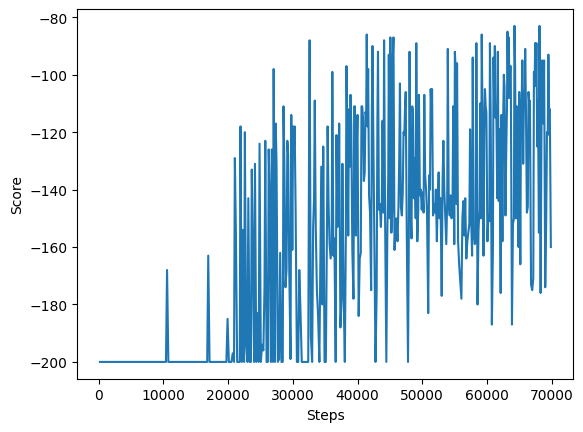

In [68]:
all_rewards = np.array(all_rewards)
plt.xlabel('Steps')
plt.ylabel('Score')
plt.plot(all_rewards[:, 0], all_rewards[:, 1])

In [69]:
env = Recorder(env, './video')
state = env.reset()
done = False
total_reward = 0.0
q_net.eval()

with torch.no_grad():
    while not done:
        #action = env.action_space.sample()
        action = q_net.choose_action(state)
        next_state, reward, done, info = env.step(action)
        total_reward += reward
        state = next_state

print(total_reward)
env.play()

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(

See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(



-113.0
Moviepy - Building video __temp__.mp4.
Moviepy - Writing video __temp__.mp4



Moviepy - Done !
Moviepy - video ready __temp__.mp4


# **Nhận xét**
## Thay đổi từ mạng **Neural** thành mạng **Duelling**
## Thay đổi min_epsilon từ **0.01** thành **0.001**
## Thay đổi max_num_steps từ **50000** thành **70000**
## Thay đổi epsilon_decay_intervals từ **10000** thành **1000**
## Thay đổi alpha từ **5e-4** thành **0.0015**
## Thay đổi memory_size từ **50000** thành **100000**
## Thay đổi min_replay_size từ **1000** thành **5000**
## Thay đổi batch_size từ **32** thành **64**
## Thay đổi target_update_frequency từ **1000** thành **500**
